In [1]:
import warnings

import geopandas as gpd
import numpy as np
import pandas as pd
import proplot
import ujson as json
from pygeohydro import NWIS
from pynhd import NLDI, AGRBase
from rio_tiler.io import COGReader

In [2]:
warnings.filterwarnings("ignore", message=".*rio-tiler performances.*")

In [3]:
def population_agg(geo_df: gpd.GeoDataFrame) -> pd.DataFrame:
    """Get population within a dataframe of polygons from Facebook's HRSL.

    HRSL estimates the number of people living within 30-meter grid.
    """
    HRSL = "/".join(
        [
            "https://dataforgood-fb-data.s3.amazonaws.com",
            "hrsl-cogs/hrsl_general/hrsl_general-latest.vrt",
        ]
    )

    def agg(pop: np.ndarray, areasqkm: float) -> int:
        return np.nansum(pop) * areasqkm * 1e6 / (30 ** 2 * pop.size)

    with COGReader(HRSL) as cog:
        gdf = geo_df.to_crs(cog.dataset.crs)
        pop = pd.DataFrame.from_dict(
            {
                feat["id"]: agg(cog.feature(feat, dst_crs=cog.dataset.crs).data, area)
                for feat, area in zip(json.loads(gdf.geometry.to_json())["features"], gdf.areasqkm)
            },
            orient="index",
        )
        pop.index = pop.index.astype(gdf.index.dtype)

    return pop

In [4]:
def catchments(station: str) -> gpd.GeoDataFrame:
    """Get local catchments for a USGS station."""
    nldi = NLDI()
    nwis = NWIS()

    info = nwis.get_info({"site": station})
    coords = (info.dec_long_va.iloc[0], info.dec_lat_va.iloc[0])
    trib = nldi.navigate_byloc(coords, "upstreamTributaries", "flowlines")
    trib = trib.set_index("nhdplus_comid")

    url = "https://watersgeo.epa.gov/arcgis/rest/services/NHDPlus/NHDPlus/MapServer"
    epa = AGRBase(url, layer="catchment")
    wb = epa.byids("FEATUREID", trib.index.to_list())
    wb.columns = [c.lower() for c in wb.columns]
    return wb.set_index("featureid")

In [5]:
wb = catchments("08075000")
wb["population"] = population_agg(wb)

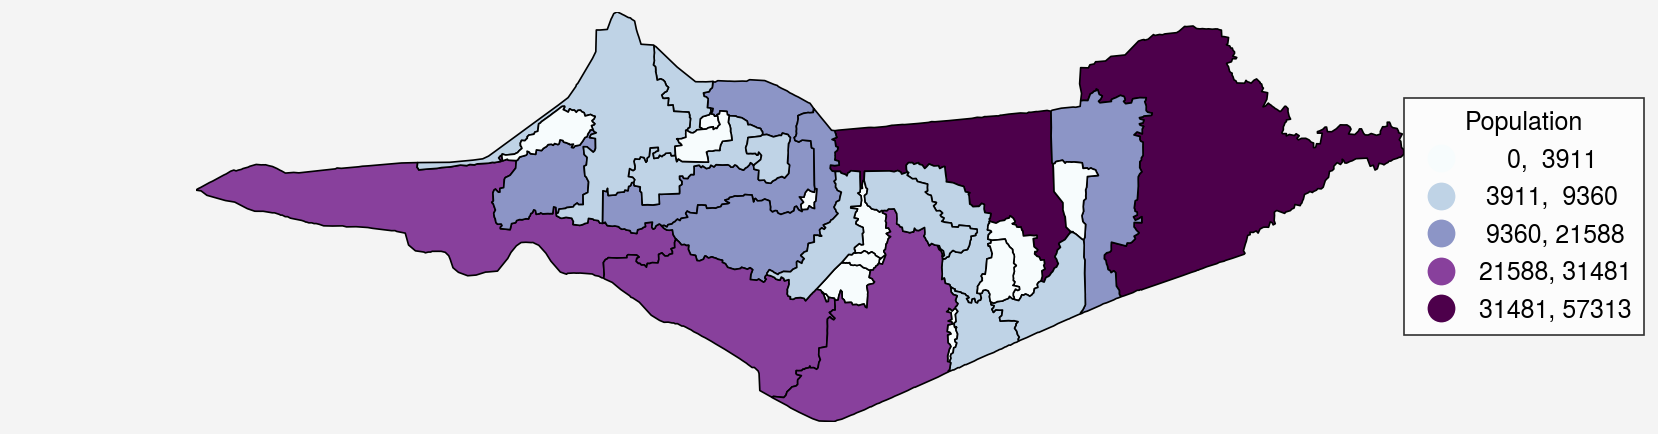

In [6]:
_, ax = proplot.subplots(refwidth=8)
wb.plot(
    ax=ax,
    column="population",
    scheme="FisherJenks",
    k=5,
    cmap="BuPu",
    edgecolor="k",
    legend=True,
    legend_kwds={
        "loc": "center left",
        "bbox_to_anchor": (1, 0.5),
        "fmt": "{:.0f}",
        "ncol": 1,
        "title": "Population",
    },
)
ax.set_axis_off()
ax.margins(0)